# HAR on full dataset


## 1. data preparation

dataset can be downloaded at:
https://www.dropbox.com/sh/1745pukanq6g94r/AAAy1zulrY25VZXh65sAWbZoa?dl=0


if you use colab, you can upload the dataset via the script below:

from google.colab import files

files.upload()


In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
import numpy as np
import scipy.io

data = scipy.io.loadmat('PAMAP2.mat')
Xy_train0 = data['Xy_train']
Xy_test0 = data['Xy_test']

print('optional: channel-wise normalisation')
mn = np.mean(Xy_train0[:,:-1], axis=0)
std = np.std(Xy_train0[:,:-1], axis=0)
Xy_train0[:,:-1] = (Xy_train0[:,:-1]-mn)/std
Xy_test0[:,:-1] = (Xy_test0[:,:-1]-mn)/std

cNum=12
win_len = 100
dim = Xy_train0.shape[1]-1 #minus the label col
print(dim)


def sliding_window(Xy, percentage=0.5, win_len=100):
    #print('per')
    print('overlapping_percentage:  '+str(percentage*100)+'%')

    batch_size0 = int(np.floor(len(Xy)/win_len))
    #print(batch_size0)
    Xy0 = Xy[:win_len*batch_size0,:]
    if percentage==1:
        print('100% overlapping means no overlapping')
        return Xy0

    K_fold = int(1/(1-percentage))
    #print(K_fold)
    offset = int(np.round(win_len * (1-percentage)))
    Xy_big = []
    for k in range(K_fold):
        #print(k)
        current_set = Xy0[k*offset:len(Xy0)-(win_len-k*offset),:]
        #print(len(current_set))
        Xy_big.append(current_set)
    return np.concatenate(Xy_big)

def _to_frames(Xy, dim, win_len=100):
    X3D = np.reshape(Xy[:,:-1], (-1, win_len, dim))
    y2D = np.reshape(Xy[:,-1],(-1, win_len)).astype(int)
    y = np.zeros(len(y2D))
    for i in range(len(y2D)):
        counts = np.bincount(np.reshape(y2D[i, :], (-1)))
        y[i] = np.argmax(counts)
    return X3D, y

optional: channel-wise normalisation
27


#### we can increase the training size by increasing the overlapping percentage.

In [3]:
print(Xy_train0.shape)
Xy_train = sliding_window(Xy_train0, 0.5, win_len)
print(Xy_train.shape)
X_train0, y_train0 = _to_frames(Xy_train,dim, win_len)


#print(Xy_test0.shape)
Xy_test = sliding_window(Xy_test0, 0.5, win_len)
#print(Xy_test.shape)
X_test0, y_test0 = _to_frames(Xy_test,dim,win_len)

(473445, 28)
overlapping_percentage:  50.0%
(946600, 28)
overlapping_percentage:  50.0%


----------train_Data---------------
class 0, sample number 275, percentage 2.9%
class 1, sample number 971, percentage 10.3%
class 2, sample number 902, percentage 9.5%
class 3, sample number 957, percentage 10.1%
class 4, sample number 1205, percentage 12.7%
class 5, sample number 337, percentage 3.6%
class 6, sample number 797, percentage 8.4%
class 7, sample number 901, percentage 9.5%
class 8, sample number 596, percentage 6.3%
class 9, sample number 540, percentage 5.7%
class 10, sample number 867, percentage 9.2%
class 11, sample number 1118, percentage 11.8%


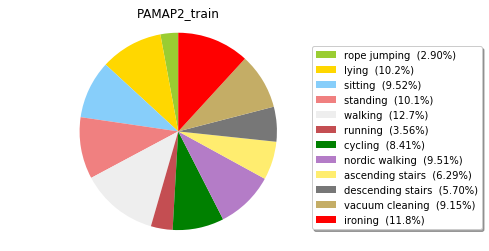

----------testing_Data--------------
class 0, sample number 50, percentage 1.4%
class 1, sample number 313, percentage 9.0%
class 2, sample number 333, percentage 9.6%
class 3, sample number 309, percentage 8.9%
class 4, sample number 384, percentage 11.0%
class 5, sample number 317, percentage 9.1%
class 6, sample number 301, percentage 8.6%
class 7, sample number 353, percentage 10.1%
class 8, sample number 183, percentage 5.3%
class 9, sample number 161, percentage 4.6%
class 10, sample number 303, percentage 8.7%
class 11, sample number 473, percentage 13.6%


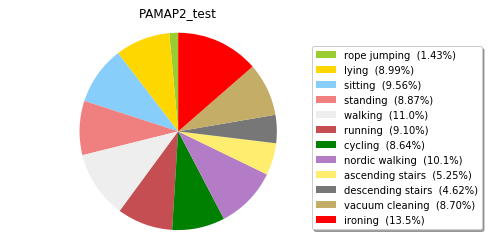

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
def drawing_pie_chart(percentages, labels, dataset_id):
    plt.title(dataset_id)
    color_set = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral',
            '#eeeeee','#C44E52', 'green', '#B47CC7','#ffed6f','#777777','#C4AD66','red', 
                  'blue',  'cyan', 'magenta',
                '#FBC15E','#56B4E9','#4878CF','#FFFEA3' ]
    
    labels = labels.copy()
    for i in range(len(percentages)):
        labels[i] = labels[i]+'  ('+str(percentages[i])[:4]+'%)'
    colors = color_set[:len(percentages)]
    
    
    patches, texts = plt.pie(percentages, colors=colors, startangle=90)
    
    plt.axis('equal')
    lgd = plt.legend(labels, loc=(0.9, 0.05), shadow=True, borderaxespad=10.)
    
    
    #plt.savefig('dataset_'+dataset_id+'.eps', bbox_extra_artists=(lgd,), bbox_inches='tight', format='eps', dpi=600)
    plt.show()
    
def calculating_percentages(y_, cNum):
    percentages = np.zeros(cNum)
    for i in range(cNum):
        num = np.sum(y_==i)
        percentages[i]=100.0*num/len(y_)
        print('class {}, sample number {}, percentage {:.1f}%'.format(i, num, percentages[i]))
    return percentages


dataset_id = 'PAMAP2'
labels_PAMAP2 = [r'rope jumping', 
                 r'lying', 
                 r'sitting', 
                 r'standing',
                 r'walking', 
                 r'running', 
                 r'cycling', 
                 r'nordic walking',
                 r'ascending stairs', 
                 r'descending stairs', 
                 r'vacuum cleaning', 
                 r'ironing']
cNum = 12 # 12 classes for PAMAP2

print('----------train_Data---------------')
percentages_train = calculating_percentages(y_train0, cNum)
drawing_pie_chart(percentages_train,labels_PAMAP2,dataset_id+'_train')

print('----------testing_Data--------------')
percentages_test = calculating_percentages(y_test0, cNum)
drawing_pie_chart(percentages_test,labels_PAMAP2,dataset_id+'_test')

#### performing feature engineering (and normalisation)

In [5]:
from scipy.stats import kurtosis, skew, iqr, median_absolute_deviation 
def _FE(X):
    X_mean = np.mean(X, axis=1)
    X_std = np.std(X, axis=1)
    X_var = np.var(X, axis=1)
    X_energy = np.sqrt(np.mean(np.power(X, 2), axis=1))
    X_mad= np.mean(np.abs(X - np.expand_dims(X_mean, axis=1)), axis=1)
    X_mad1 = median_absolute_deviation(X, axis=1)
    X_kurtosis = kurtosis(X, axis = 1)
    X_skew = skew(X, axis = 1)
    X_iqr = iqr(X, axis = 1)
    X_max = np.amax(X, axis=1)
    X_min = np.amin(X, axis=1)
    
    return np.concatenate((X_mean 
                           ,X_std
                           ,X_var
                           ,X_energy
                           ,X_mad
                           ,X_mad1
                           ,X_kurtosis
                           ,X_skew
                           ,X_iqr
                           ,X_max
                           ,X_min
                          ), axis=1)



#print('performing feature engineering')
X_train = _FE(X_train0)
X_test = _FE(X_test0)
print('new feature dimension: '+str(X_train.shape[1]))
y_train = y_train0.copy()
y_test = y_test0.copy()



print('performing feature-wise normalisation!')
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(X_train)
# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

new feature dimension: 297
performing feature-wise normalisation!


#### We work on default hyper-parameters.


In [7]:
from time import time
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score


print('training size', X_train.shape[0] )
names = ["_LR", "SVM", 'RBF', "_DT", "_RF", "KNN"]

classifiers = [
    LogisticRegression(solver = 'lbfgs'),
    SVC(kernel="linear"),
    SVC(kernel="rbf"),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=100),
    KNeighborsClassifier(5)]

for name, clf in zip(names, classifiers):
    t0 = time()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    mean_f1 = f1_score(y_test, y_pred, average='macro')  
    weighted_f1 = f1_score(y_test, y_pred, average='weighted') 
    acc = accuracy_score(y_test, y_pred)
    print(name+'     mean-f1: {:.2f}, weighted-f1: {:.2f}, acc: {:.2f}, total_time: {:.2f} sec'.format(mean_f1, weighted_f1, 
                                                                                                   acc, time()-t0))
    
 
    

   

   

training size 9466
_LR     mean-f1: 0.85, weighted-f1: 0.85, acc: 0.86, total_time: 3.99 sec
SVM     mean-f1: 0.76, weighted-f1: 0.77, acc: 0.78, total_time: 5.88 sec
RBF     mean-f1: 0.87, weighted-f1: 0.87, acc: 0.87, total_time: 12.02 sec
_DT     mean-f1: 0.65, weighted-f1: 0.65, acc: 0.67, total_time: 3.07 sec
_RF     mean-f1: 0.91, weighted-f1: 0.91, acc: 0.91, total_time: 10.44 sec
KNN     mean-f1: 0.86, weighted-f1: 0.86, acc: 0.86, total_time: 16.94 sec
